# Models
Creates 4 models <br>
Currently a work in progress

In [63]:
import pandas as pd
import numpy as np
import pickle
import os
import math
import warnings
import re
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

baseball_path = r"C:\Users\james\Documents\MLB\Data"

In [64]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import joblib

# Create sample dataset

In [65]:
# Read in sample dataset (calculated from API)
sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Sample100.csv"))
sample['date'] = sample['date'].str.replace("-", "")

In [66]:
# Read in FanGraphs batter projections for each day
batters_fg_sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Batters FanGraphs.csv"))
# Convert date to string for merge
batters_fg_sample['date'] = batters_fg_sample['date'].astype('str')

# Merge sample data with projections
sample = sample.merge(batters_fg_sample, left_on=['batter', 'date'], right_on=['mlbamid', 'date'], how='inner', suffixes=("_b"))
# Delete to clear up space
del batters_fg_sample

# Read in FanGraphs pitcher projections for each day
pitchers_fg_sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Pitchers FanGraphs.csv"))
# Convert date to string for merge
pitchers_fg_sample['date'] = pitchers_fg_sample['date'].astype('str')

# Merge sample data with projections
sample = sample.merge(pitchers_fg_sample, left_on=['pitcher', 'date'], right_on=['mlbamid', 'date'], how='inner', suffixes=("_p"))
# Delete to clear up space
del pitchers_fg_sample

C:\Users\james\AppData\Local\Temp\ipykernel_29136\2574452826.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  batters_fg_sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Batters FanGraphs.csv"))
C:\Users\james\AppData\Local\Temp\ipykernel_29136\2574452826.py:7: FutureWarning: Passing 'suffixes' as a <class 'str'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  sample = sample.merge(batters_fg_sample, left_on=['batter', 'date'], right_on=['mlbamid', 'date'], how='inner', suffixes=("_b"))
C:\Users\james\AppData\Local\Temp\ipykernel_29136\2574452826.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  pitchers_fg_sample = pd.read_csv(os.path.join(baseball_path, "Inputs", "Pitchers FanGraphs.csv"))
C:\Users\james\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1214: Runt

# Model Inputs

In [67]:
# Inputs
batter_stats_short = ['b1_b','b2_b','b3_b','hr_b','bb_b','hbp_b',
                'so_b','fo_b','go_b','lo_b','po_b',
                'iso_b','slg_b','obp_b','woba_b',
                'to_left_b','to_middle_b','to_right_b',
                'hard_hit_b','totalDistance_b','launchSpeed_b','maxSpeed_b','maxSpin_b',
                'ab_b','pa_b']

batter_stats_long =  ['b1_b_long','b2_b_long','b3_b_long','hr_b_long','bb_b_long','hbp_b_long',
                'so_b_long','fo_b_long','go_b_long','lo_b_long','po_b_long',
                'iso_b_long','slg_b_long','obp_b_long','woba_b_long',
                'to_left_b_long','to_middle_b_long','to_right_b_long',
                'hard_hit_b_long','totalDistance_b_long','launchSpeed_b_long','maxSpeed_b_long','maxSpin_b_long',
                'ab_b_long','pa_b_long']

pitcher_stats_short = ['b1_p','b2_p','b3_p','hr_p','bb_p','hbp_p',
                 'so_p','fo_p','go_p','lo_p','po_p',
                 'iso_p','slg_p','obp_p','woba_p',
                 'to_left_p','to_middle_p','to_right_p',
                 'hard_hit_p','totalDistance_p','launchSpeed_p','maxSpeed_p','maxSpin_p',
                 'ab_p','pa_p']

pitcher_stats_long = ['b1_p_long','b2_p_long','b3_p_long','hr_p_long','bb_p_long','hbp_p_long',
                 'so_p_long','fo_p_long','go_p_long','lo_p_long','po_p_long',
                 'iso_p_long','slg_p_long','obp_p_long','woba_p_long',
                 'to_left_p_long','to_middle_p_long','to_right_p_long',
                 'hard_hit_p_long','totalDistance_p_long','launchSpeed_p_long','maxSpeed_p_long','maxSpin_p_long',
                 'ab_p_long','pa_p_long']

batter_stats_fg = ['b1_rate','b2_rate','b3_rate','hr_rate','bb_rate','hbp_rate','so_rate', 'woba', 'slg', 'obp']

pitcher_stats_fg = ['H/9','HR/9','K/9','BB/9']


venues = ['venue_1', 'venue_2', 'venue_3', 'venue_4', 'venue_5', 'venue_7', 'venue_10', 'venue_12', 
          'venue_13', 'venue_14', 'venue_15', 'venue_16', 'venue_17', 'venue_19', 'venue_22', 'venue_31', 
          'venue_32', 'venue_680', 'venue_2392', 'venue_2394', 'venue_2395', 'venue_2535', 'venue_2536', 
          'venue_2602', 'venue_2680', 'venue_2681', 'venue_2701', 'venue_2735', 'venue_2756', 'venue_2889', 
          'venue_3289', 'venue_3309', 'venue_3312', 'venue_3313', 'venue_4169', 'venue_4705', 'venue_5010', 
          'venue_5325', 'venue_5365', 'venue_5381', 'venue_5445']

years = ['year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023']

other_list = ['p_L','b_L','x_vect','y_vect','temperature','onFirst','onSecond','onThird','inning','top','score_diff']

In [68]:
# Remove items that do not apply to batters or pitchers
batter_stats_short.remove("maxSpeed_b")
batter_stats_short.remove("maxSpin_b")
batter_stats_long.remove("maxSpeed_b_long")
batter_stats_long.remove("maxSpin_b_long")

pitcher_stats_short.remove("totalDistance_p")
pitcher_stats_long.remove("totalDistance_p_long")
pitcher_stats_short.remove("launchSpeed_p")
pitcher_stats_long.remove("launchSpeed_p_long")


# # Not sure why but these are weird
# batter_stats.remove("launchSpeed_b")
# batter_stats.remove("totalDistance_b")
# batter_stats.remove("launchSpeed_b_long")
# batter_stats.remove("totalDistance_b_long")

# pitcher_stats.remove("maxSpeed_p")
# pitcher_stats.remove("maxSpin_p")
# pitcher_stats.remove("maxSpeed_p_long")
# pitcher_stats.remove("maxSpin_p_long")


# Testing removing these
batter_stats_short.remove('ab_b')
batter_stats_short.remove('pa_b')
batter_stats_long.remove('ab_b_long')
batter_stats_long.remove('pa_b_long')

pitcher_stats_short.remove('ab_p')
pitcher_stats_short.remove('pa_p')
pitcher_stats_long.remove('ab_p_long')
pitcher_stats_long.remove('pa_p_long')

batter_stats = batter_stats_short + batter_stats_long
pitcher_stats = pitcher_stats_short + pitcher_stats_long

In [69]:
# Select variables for each model
# Full batter data, full pitcher data
x_list1 = batter_stats + pitcher_stats + venues + years + other_list 
# Full batter data, short pitcher data
x_list2 = batter_stats + pitcher_stats_fg + venues + years + other_list 
# Short batter data, long pitcher data
x_list3 = batter_stats_fg + pitcher_stats + venues + years + other_list 
# Short batter data, short pitcher data
x_list4 = batter_stats_fg + pitcher_stats_fg + venues + years + other_list 

print(len(x_list1))
# Variables we want to look at for each model (those we're training on plus names and some basic stats as well as the outcome)
x_list1_plus = x_list1 + ['batterName', 'pitcherName', 'batter', 'pitcher', 'batSide', 'pitchHand', 'eventsModel']
x_list2_plus = x_list2 + ['batterName', 'pitcherName', 'batter', 'pitcher', 'batSide', 'pitchHand', 'eventsModel']
x_list3_plus = x_list3 + ['batterName', 'pitcherName', 'batter', 'pitcher', 'batSide', 'pitchHand', 'eventsModel']
x_list4_plus = x_list4 + ['batterName', 'pitcherName', 'batter', 'pitcher', 'batSide', 'pitchHand', 'eventsModel']

145


# Clean Data

In [70]:
# Get rid of small samples when training
sample = sample.query('pa_b_long >= 40').query('pa_p_long >= 40')

# Get rid of PA outcomes that are not valid outputs
sample = sample.query('eventsModel != "Cut"').reset_index(drop=True)

# Note: inner merge of FanGraphs data will remove observations without both batter and pitcher projections

In [71]:
sample.fillna(0, inplace=True)

In [72]:
# Set directory to models folder 
os.chdir(r"C:\Users\james\Documents\MLB\Code\Models")

# Model 1
##### Complete batter variables
##### Complete pitcher variables

In [73]:
# Split into training and testing groups
X_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_train = X_train[x_list1]
X_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
X_test = X_test[x_list1]
y_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
y_train = y_train['eventsModel']
y_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
y_test = y_test['eventsModel']

In [74]:
# Scale (hopefully deprecated)
scaler = StandardScaler()
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [134]:
# 27, 34, 35
layers = (22,22)
layers_str = ''.join(str(x) for x in layers)

filename = "model1_" + layers_str + "s_100.sav"

# Train model
model1 = MLPClassifier(hidden_layer_sizes=layers, activation='relu', verbose=True, random_state=1, max_iter=15).fit(X_train, y_train)
# model1 = MLPClassifier(hidden_layer_sizes=(30,30), activation='relu', verbose=True, random_state=1, max_iter=200).fit(sample[x_list1], sample[['eventsModel']].values.ravel())
pickle.dump(model1, open(filename, 'wb'))

Iteration 1, loss = 2.07269726
Iteration 2, loss = 2.03061113
Iteration 3, loss = 2.02745777
Iteration 4, loss = 2.02509033
Iteration 5, loss = 2.02304593
Iteration 6, loss = 2.02128027
Iteration 7, loss = 2.01986028
Iteration 8, loss = 2.01901413
Iteration 9, loss = 2.01831245
Iteration 10, loss = 2.01775868
Iteration 11, loss = 2.01726925
Iteration 12, loss = 2.01666551
Iteration 13, loss = 2.01605471
Iteration 14, loss = 2.01554614
Iteration 15, loss = 2.01522333


C:\Users\james\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


In [135]:
# Keep relevant variables in dataset
sample1 = sample[x_list1_plus].reset_index()
# Rename index to make a merge ID
sample1.rename(columns={'index':'merge'}, inplace=True)

# Predict PA probabilities
try:
    X_test.drop(columns={'b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so'}, inplace=True)
except:
    pass

X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']] = model1.predict_proba(X_test)

# Keep PA probabilities
X_merge = X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']].reset_index()
# Rename index to make a merge ID
X_merge.rename(columns={'level_1':'merge'}, inplace=True)

# Merge PA probabilities in test sample onto full sample, keeping those that merge
X_merge = X_merge.merge(sample1, on='merge', how='inner')
X_merge

,year,merge,b1,b2,b3,bb,fo,go,hbp,hr,...,inning,top,score_diff,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel
0,2015,85818,0.171061,0.055421,0.004549,0.052565,0.118333,0.277390,0.008445,0.045357,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
1,2015,85819,0.171061,0.055421,0.004549,0.052565,0.118333,0.277390,0.008445,0.045357,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
2,2015,85820,0.171061,0.055421,0.004549,0.052565,0.118333,0.277390,0.008445,0.045357,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
3,2015,85821,0.171061,0.055421,0.004549,0.052565,0.118333,0.277390,0.008445,0.045357,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
4,2015,85822,0.171002,0.055499,0.004387,0.048538,0.121839,0.275104,0.008223,0.044604,...,5,0,4.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421840,2023,1265543,0.149572,0.048680,0.004523,0.078299,0.117611,0.239592,0.010686,0.040407,...,6,0,0.0,AJ Pollock,Zack Thompson,572041,668868,R,L,lo
421841,2023,1265544,0.169404,0.037079,0.005045,0.074118,0.086407,0.325369,0.011370,0.011794,...,7,0,0.0,Kolten Wong,Zack Thompson,543939,668868,L,L,bb
421842,2023,1265545,0.170570,0.040643,0.005588,0.081985,0.090112,0.318149,0.011406,0.015739,...,7,0,0.0,J.P. Crawford,Zack Thompson,641487,668868,L,L,b1
421843,2023,1265546,0.127931,0.034820,0.003495,0.091055,0.095815,0.220208,0.012499,0.020912,...,8,0,2.0,Jarred Kelenic,Genesis Cabrera,672284,650893,L,L,go


Axes(0.125,0.11;0.775x0.77)
0.00010365273938128213


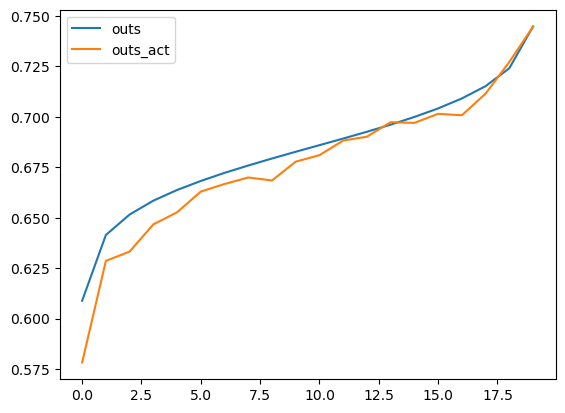

In [136]:
X_merge['outs'] = X_merge[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
X_merge.loc[X_merge['eventsModel'].isin(['so', 'fo', 'go', 'lo', 'po']), 'outs_act'] = 1
X_merge['outs_act'].fillna(0, inplace=True)

X_merge[['outs', 'outs_act']]

X_merge['decile'] = pd.qcut(X_merge['outs'], 20, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[['outs', 'outs_act']].plot.line())
test['outs_mse'] = (test['outs'] - test['outs_act']) ** 2
print(test['outs_mse'].mean())

Axes(0.125,0.11;0.775x0.77)
0.0003730108924621415


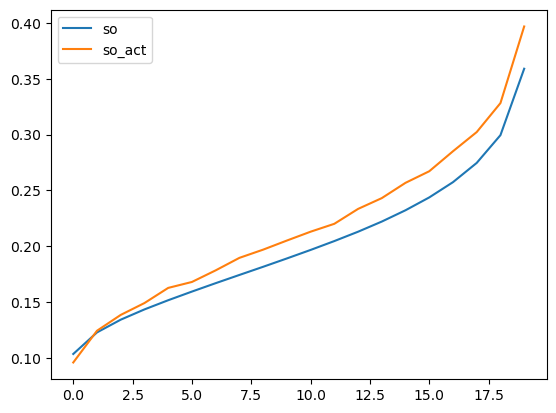

In [137]:
var = "so"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 20, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())

test['so_mse'] = (test['so'] - test['so_act']) ** 2
print(test['so_mse'].mean())

Axes(0.125,0.11;0.775x0.77)
2.0472820417438327e-05


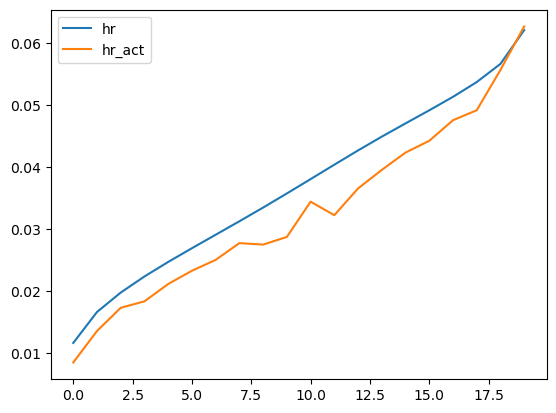

In [138]:
var = "hr"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 20, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())
test['hr_mse'] = (test['hr'] - test['hr_act']) ** 2
print(test['hr_mse'].mean())

Axes(0.125,0.11;0.775x0.77)
1.8915677846818068e-05


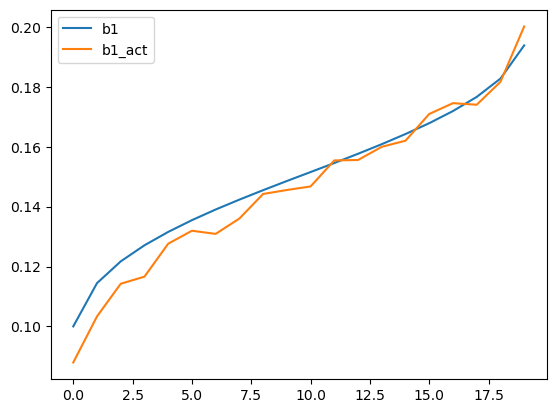

In [139]:
var = "b1"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 20, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())
test['hr_mse'] = (test['hr'] - test['hr_act']) ** 2
print(test['hr_mse'].mean())

Axes(0.125,0.11;0.775x0.77)
1.939119779203805e-05


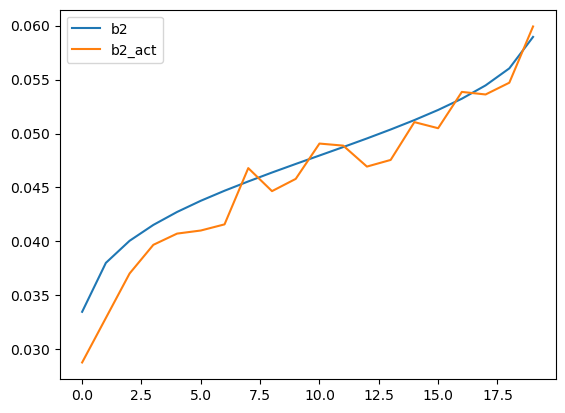

In [140]:
var = "b2"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 20, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())
test['hr_mse'] = (test['hr'] - test['hr_act']) ** 2
print(test['hr_mse'].mean())

Axes(0.125,0.11;0.775x0.77)
1.840643357003345e-05


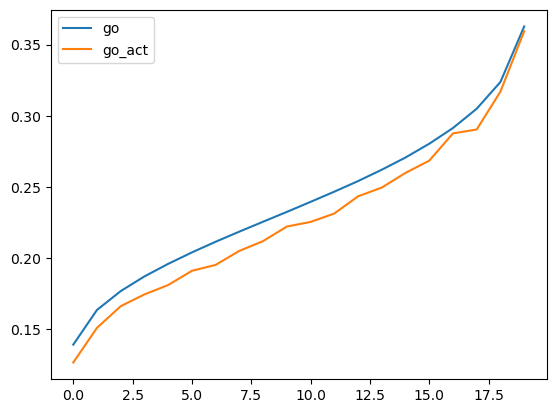

In [141]:
var = "go"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 20, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())
test['hr_mse'] = (test['hr'] - test['hr_act']) ** 2
print(test['hr_mse'].mean())

2020s 1.5386613045289035e-06 very good <br>
2222s 3.776960722985193e-06 hr_act > <br>
3030s 1.7960040413697248e-05 hr > <br>
5555s 6.377837354566379e-06 inconsistent <br>
3535s 6.339632966574814e-06 perfect for the first half, then hr > <br>

# Model 2
##### Complete batter variables
##### Short pitcher variables

In [177]:
# Split into training and testing groups
X_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_train = X_train[x_list2]
X_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
X_test = X_test[x_list2]
y_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
y_train = y_train['eventsModel']
y_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
y_test = y_test['eventsModel']

In [178]:
# Scale
scaler = StandardScaler()
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [179]:
# Train model
# model2 = MLPClassifier(hidden_layer_sizes=(200,200,200), activation='relu', verbose=True, random_state=1, max_iter=200).fit(X_train, y_train)
model2 = MLPClassifier(hidden_layer_sizes=(25,25), activation='relu', verbose=True, random_state=1, max_iter=200).fit(sample[x_list2], sample[['eventsModel']].values.ravel())
filename = "model2_2525l_100.sav"
pickle.dump(model2, open(filename, 'wb'))

Iteration 1, loss = 2.04564704
Iteration 2, loss = 2.02432714
Iteration 3, loss = 2.02138869
Iteration 4, loss = 2.01999723
Iteration 5, loss = 2.01918539
Iteration 6, loss = 2.01849115
Iteration 7, loss = 2.01799417
Iteration 8, loss = 2.01743654
Iteration 9, loss = 2.01702652
Iteration 10, loss = 2.01669499
Iteration 11, loss = 2.01635659
Iteration 12, loss = 2.01613708
Iteration 13, loss = 2.01592429
Iteration 14, loss = 2.01573169
Iteration 15, loss = 2.01568653
Iteration 16, loss = 2.01542603
Iteration 17, loss = 2.01531016
Iteration 18, loss = 2.01518588
Iteration 19, loss = 2.01511187
Iteration 20, loss = 2.01493426
Iteration 21, loss = 2.01495245
Iteration 22, loss = 2.01487366
Iteration 23, loss = 2.01472004
Iteration 24, loss = 2.01464931
Iteration 25, loss = 2.01468618
Iteration 26, loss = 2.01448339
Iteration 27, loss = 2.01449549
Iteration 28, loss = 2.01441612
Iteration 29, loss = 2.01432183
Iteration 30, loss = 2.01422527
Iteration 31, loss = 2.01428757
Iteration 32, los

In [180]:
# Keep relevant variables in dataset
sample2 = sample[x_list2_plus].reset_index()
# Rename index to make a merge ID
sample2.rename(columns={'index':'merge'}, inplace=True)

# Predict PA probabilities
X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']] = model2.predict_proba(X_test)

# Keep PA probabilities
X_merge = X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']].reset_index()
# Rename index to make a merge ID
X_merge.rename(columns={'level_1':'merge'}, inplace=True)

# Merge PA probabilities in test sample onto full sample, keeping those that merge
X_merge = X_merge.merge(sample2, on='merge', how='inner')
X_merge

,year,merge,b1,b2,b3,bb,fo,go,hbp,hr,...,inning,top,score_diff,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel
0,2015,85818,0.169892,0.059162,0.004633,0.066550,0.109956,0.280875,0.004903,0.041824,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
1,2015,85819,0.169892,0.059162,0.004633,0.066550,0.109956,0.280875,0.004903,0.041824,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
2,2015,85820,0.169892,0.059162,0.004633,0.066550,0.109956,0.280875,0.004903,0.041824,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
3,2015,85821,0.169892,0.059162,0.004633,0.066550,0.109956,0.280875,0.004903,0.041824,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
4,2015,85822,0.173740,0.062150,0.005333,0.068710,0.109423,0.278947,0.004993,0.045084,...,5,0,4.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421840,2023,1265543,0.135959,0.044705,0.002028,0.106375,0.121196,0.230266,0.008874,0.038994,...,6,0,0.0,AJ Pollock,Zack Thompson,572041,668868,R,L,lo
421841,2023,1265544,0.152162,0.034597,0.002605,0.104009,0.105130,0.287278,0.011591,0.012506,...,7,0,0.0,Kolten Wong,Zack Thompson,543939,668868,L,L,bb
421842,2023,1265545,0.149225,0.037552,0.002753,0.114617,0.118321,0.265217,0.010390,0.015228,...,7,0,0.0,J.P. Crawford,Zack Thompson,641487,668868,L,L,b1
421843,2023,1265546,0.115695,0.035572,0.002503,0.133397,0.108313,0.194369,0.010401,0.025149,...,8,0,2.0,Jarred Kelenic,Genesis Cabrera,672284,650893,L,L,go


AxesSubplot(0.125,0.125;0.775x0.755)
5.891033800828112e-05


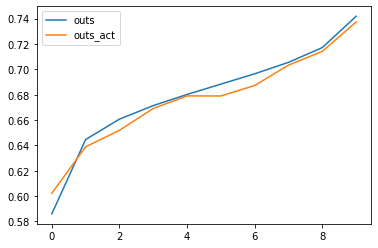

In [181]:
X_merge['outs'] = X_merge[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
X_merge.loc[X_merge['eventsModel'].isin(['so', 'fo', 'go', 'lo', 'po']), 'outs_act'] = 1
X_merge['outs_act'].fillna(0, inplace=True)

X_merge[['outs', 'outs_act']]

X_merge['decile'] = pd.qcut(X_merge['outs'], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[['outs', 'outs_act']].plot.line())
test['outs_mse'] = (test['outs'] - test['outs_act']) ** 2
print(test['outs_mse'].mean())

2020l 7.561915367706961e-05 outs > <br>
2222l 0.00020822318137444108 outs >> <br>
2424l 4.14255160761689e-05 outs_act > <br>
2626l 7.15981439366018e-05 outs > <br>
2828l 4.419570805315857e-06 gorgeous <br>
2121l 3.7583489343184066e-05 outs > <br>
2323l 0.00022508341791312652 outs >> <br>
2525l 5.891033800828112e-05 outs > but barely <br>

AxesSubplot(0.125,0.125;0.775x0.755)
3.728487113230222e-05


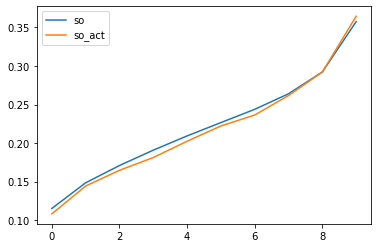

In [182]:
var = "so"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())

test['so_mse'] = (test['so'] - test['so_act']) ** 2
print(test['so_mse'].mean())

2020l 2.0166318078224668e-05 - perfect  <br>
2222l 0.0005325922527257199 - so >>  <br> 
2424l 0.0001726526240688736 so_act > <br>
2626l 0.00035968765580473173 so >> <br>
2828l 0.00020964583123462085 so_act >> <br>
2121l 1.2515327714660206e-05 perfect <br>
2323l 0.00038254173954805845 so_act >> <br>
2525l 3.728487113230222e-05 so > but barely <br>

AxesSubplot(0.125,0.125;0.775x0.755)
3.123346138155408e-06


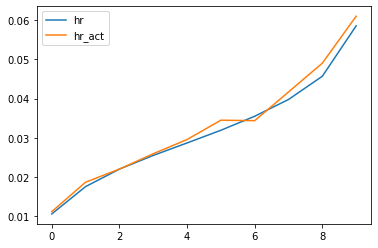

In [183]:
var = "hr"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())
test['hr_mse'] = (test['hr'] - test['hr_act']) ** 2
print(test['hr_mse'].mean())

2020l 2.1635546039730588e-05 hr >> <br>
2222l 2.8329508128621513e-06 perfect <br>
2424l 5.234515342856711e-06 hr_act>  <br>
2626l 3.0717457402457726e-06 hr > <br>
2828l 7.599075850723734e-06 hr > <br>
2121l 6.265916409853632e-06 hr > <br>
2323l 7.123085768265674e-06 hr_act > <br>
2525l 3.123346138155408e-06 hr_act > but barely. <br>

2525l is best so far, could be better

# Model 3
##### Short batter variables
##### Complete pitcher variables

In [233]:
# Split into training and testing groups
X_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_train = X_train[x_list3]
X_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
X_test = X_test[x_list3]
y_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
y_train = y_train['eventsModel']
y_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
y_test = y_test['eventsModel']

In [234]:
# Scale
scaler = StandardScaler()
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [235]:
# Train model
# model3 = MLPClassifier(hidden_layer_sizes=(200,200,200), activation='relu', verbose=True, random_state=1, max_iter=200).fit(X_train, y_train)
model3 = MLPClassifier(hidden_layer_sizes=(26,26), activation='relu', verbose=True, random_state=1, max_iter=200).fit(sample[x_list3], sample[['eventsModel']].values.ravel())
filename = "model3_2626l_100.sav"
pickle.dump(model3, open(filename, 'wb'))

Iteration 1, loss = 2.05399647
Iteration 2, loss = 2.02841326
Iteration 3, loss = 2.02490473
Iteration 4, loss = 2.02319493
Iteration 5, loss = 2.02206157
Iteration 6, loss = 2.02134165
Iteration 7, loss = 2.02086255
Iteration 8, loss = 2.02031336
Iteration 9, loss = 2.01993914
Iteration 10, loss = 2.01960393
Iteration 11, loss = 2.01909028
Iteration 12, loss = 2.01905501
Iteration 13, loss = 2.01875630
Iteration 14, loss = 2.01834969
Iteration 15, loss = 2.01817169
Iteration 16, loss = 2.01807079
Iteration 17, loss = 2.01785398
Iteration 18, loss = 2.01763227
Iteration 19, loss = 2.01746096
Iteration 20, loss = 2.01742397
Iteration 21, loss = 2.01729869
Iteration 22, loss = 2.01717260
Iteration 23, loss = 2.01713506
Iteration 24, loss = 2.01706543
Iteration 25, loss = 2.01693180
Iteration 26, loss = 2.01676208
Iteration 27, loss = 2.01676733
Iteration 28, loss = 2.01673601
Iteration 29, loss = 2.01664433
Iteration 30, loss = 2.01655061
Iteration 31, loss = 2.01636330
Iteration 32, los

In [236]:
# Keep relevant variables in dataset
sample3 = sample[x_list3_plus].reset_index()
# Rename index to make a merge ID
sample3.rename(columns={'index':'merge'}, inplace=True)

# Predict PA probabilities
X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']] = model3.predict_proba(X_test)

# Keep PA probabilities
X_merge = X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']].reset_index()
# Rename index to make a merge ID
X_merge.rename(columns={'level_1':'merge'}, inplace=True)

# Merge PA probabilities in test sample onto full sample, keeping those that merge
X_merge = X_merge.merge(sample3, on='merge', how='inner')
X_merge

,year,merge,b1,b2,b3,bb,fo,go,hbp,hr,...,inning,top,score_diff,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel
0,2015,85818,0.151876,0.050565,0.010909,0.058772,0.118132,0.214723,0.010373,0.035599,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
1,2015,85819,0.151876,0.050565,0.010909,0.058772,0.118132,0.214723,0.010373,0.035599,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
2,2015,85820,0.151959,0.050636,0.010945,0.059317,0.118332,0.214792,0.010385,0.035531,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
3,2015,85821,0.151959,0.050636,0.010945,0.059317,0.118332,0.214792,0.010385,0.035531,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
4,2015,85822,0.163539,0.054127,0.011131,0.057623,0.125626,0.213308,0.012387,0.037682,...,5,0,4.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421840,2023,1265543,0.149054,0.036532,0.002417,0.090106,0.107922,0.246653,0.007378,0.025058,...,6,0,0.0,AJ Pollock,Zack Thompson,572041,668868,R,L,lo
421841,2023,1265544,0.167143,0.029156,0.003278,0.084105,0.076804,0.314371,0.012573,0.010368,...,7,0,0.0,Kolten Wong,Zack Thompson,543939,668868,L,L,bb
421842,2023,1265545,0.184489,0.029105,0.003160,0.098192,0.076858,0.332566,0.009305,0.007926,...,7,0,0.0,J.P. Crawford,Zack Thompson,641487,668868,L,L,b1
421843,2023,1265546,0.116045,0.033366,0.003251,0.102747,0.108323,0.179419,0.018154,0.028952,...,8,0,2.0,Jarred Kelenic,Genesis Cabrera,672284,650893,L,L,go


AxesSubplot(0.125,0.125;0.775x0.755)
2.9875338448123193e-05


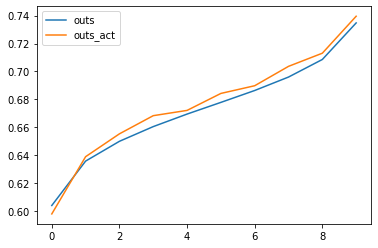

In [237]:
X_merge['outs'] = X_merge[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
X_merge.loc[X_merge['eventsModel'].isin(['so', 'fo', 'go', 'lo', 'po']), 'outs_act'] = 1
X_merge['outs_act'].fillna(0, inplace=True)

X_merge[['outs', 'outs_act']]

X_merge['decile'] = pd.qcut(X_merge['outs'], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[['outs', 'outs_act']].plot.line())
test['outs_mse'] = (test['outs'] - test['outs_act']) ** 2
print(test['outs_mse'].mean())

2020l 1.5683059209602738e-05 - good, outs_act>  <br>
2222l 0.00011492755739255498 - bad, outs_act >> <br>
2424l 3.5908363688273246e-05 - pretty good, outs_act > <br>
2626l 2.9875338448123193e-05 - even better, outs_act > <br>

AxesSubplot(0.125,0.125;0.775x0.755)
4.950272302935316e-05


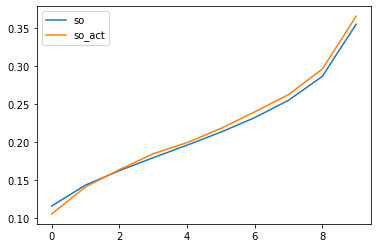

In [238]:
var = "so"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())

test['so_mse'] = (test['so'] - test['so_act']) ** 2
print(test['so_mse'].mean())

2020l - 0.00012367179338399406 good so_act > <br>
2222l - 7.320949071711585e-05 great, so_act > <br>
2424l - 6.240520766934873e-05 great <br>
2626l - 4.950272302935316e-05 even better <br>

AxesSubplot(0.125,0.125;0.775x0.755)
1.901125113225352e-06


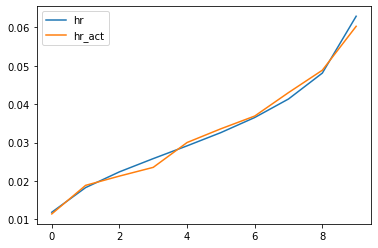

In [239]:
var = "hr"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())
test['hr_mse'] = (test['hr'] - test['hr_act']) ** 2
print(test['hr_mse'].mean())

2020l 8.441647193505494e-06 - okay but hr > <br>
2222l 5.766008541001419e-06 - okay but hr_act > <br>
2424l 4.434524217709918e-06 - quite good, but hr_act > <br>
2626l 1.901125113225352e-06 - nearly perfect <br>

In [ ]:
# 2626l is best so far

# Model 4
##### Short batter variables
##### Short pitcher variables

In [226]:
# Split into training and testing groups
X_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_train = X_train[x_list4]
X_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
X_test = X_test[x_list4]
y_train = sample.groupby(sample['year']).apply(lambda x: x.head(int(len(x)*2/3)))
y_train = y_train['eventsModel']
y_test = sample.groupby(sample['year']).apply(lambda x: x.tail(int(len(x)*1/3)))
y_test = y_test['eventsModel']

In [227]:
# Scale
scaler = StandardScaler()
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [228]:
# Train model
# model4 = MLPClassifier(hidden_layer_sizes=(200,200,200), activation='relu', verbose=True, random_state=1, max_iter=200).fit(X_train, y_train)
model4 = MLPClassifier(hidden_layer_sizes=(22,22), activation='relu', verbose=True, random_state=1, max_iter=200).fit(sample[x_list4], sample[['eventsModel']].values.ravel())
filename = "model4_2222l_100.sav"
pickle.dump(model4, open(filename, 'wb'))

Iteration 1, loss = 2.05961749
Iteration 2, loss = 2.03297563
Iteration 3, loss = 2.02783241
Iteration 4, loss = 2.02593112
Iteration 5, loss = 2.02498591
Iteration 6, loss = 2.02431381
Iteration 7, loss = 2.02348745
Iteration 8, loss = 2.02275943
Iteration 9, loss = 2.02233815
Iteration 10, loss = 2.02193164
Iteration 11, loss = 2.02168212
Iteration 12, loss = 2.02135169
Iteration 13, loss = 2.02108446
Iteration 14, loss = 2.02080524
Iteration 15, loss = 2.02074887
Iteration 16, loss = 2.02029663
Iteration 17, loss = 2.02017462
Iteration 18, loss = 2.02007327
Iteration 19, loss = 2.01984602
Iteration 20, loss = 2.01968022
Iteration 21, loss = 2.01946667
Iteration 22, loss = 2.01955190
Iteration 23, loss = 2.01930611
Iteration 24, loss = 2.01913509
Iteration 25, loss = 2.01905894
Iteration 26, loss = 2.01891630
Iteration 27, loss = 2.01884185
Iteration 28, loss = 2.01877912
Iteration 29, loss = 2.01884473
Iteration 30, loss = 2.01862799
Iteration 31, loss = 2.01851256
Iteration 32, los

In [229]:
# Keep relevant variables in dataset
sample4 = sample[x_list4_plus].reset_index()
# Rename index to make a merge ID
sample4.rename(columns={'index':'merge'}, inplace=True)

# Predict PA probabilities
X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']] = model4.predict_proba(X_test)

# Keep PA probabilities
X_merge = X_test[['b1', 'b2', 'b3', 'bb', 'fo', 'go', 'hbp', 'hr', 'lo', 'po', 'so']].reset_index()
# Rename index to make a merge ID
X_merge.rename(columns={'level_1':'merge'}, inplace=True)

# Merge PA probabilities in test sample onto full sample, keeping those that merge
X_merge = X_merge.merge(sample4, on='merge', how='inner')
X_merge

,year,merge,b1,b2,b3,bb,fo,go,hbp,hr,...,inning,top,score_diff,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel
0,2015,85818,0.158980,0.054652,0.008202,0.062029,0.105311,0.231891,0.008070,0.040720,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
1,2015,85819,0.158980,0.054652,0.008202,0.062029,0.105311,0.231891,0.008070,0.040720,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
2,2015,85820,0.159215,0.054704,0.008155,0.062501,0.105467,0.232171,0.008084,0.040713,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
3,2015,85821,0.159215,0.054704,0.008155,0.062501,0.105467,0.232171,0.008084,0.040713,...,4,0,2.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
4,2015,85822,0.161357,0.057003,0.008873,0.063904,0.113770,0.230437,0.008733,0.044515,...,5,0,4.0,Travis Shaw,Johnny Cueto,543768,456501,L,R,so
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421840,2023,1265543,0.145029,0.040831,0.002321,0.101494,0.117423,0.223887,0.011276,0.030550,...,6,0,0.0,AJ Pollock,Zack Thompson,572041,668868,R,L,lo
421841,2023,1265544,0.162816,0.031610,0.002105,0.092109,0.095187,0.275679,0.014058,0.014939,...,7,0,0.0,Kolten Wong,Zack Thompson,543939,668868,L,L,bb
421842,2023,1265545,0.178509,0.029821,0.002216,0.104323,0.096347,0.302822,0.015830,0.010614,...,7,0,0.0,J.P. Crawford,Zack Thompson,641487,668868,L,L,b1
421843,2023,1265546,0.111576,0.034444,0.001923,0.108927,0.124137,0.167855,0.012363,0.035409,...,8,0,2.0,Jarred Kelenic,Genesis Cabrera,672284,650893,L,L,go


AxesSubplot(0.125,0.125;0.775x0.755)
2.1262490527763598e-05


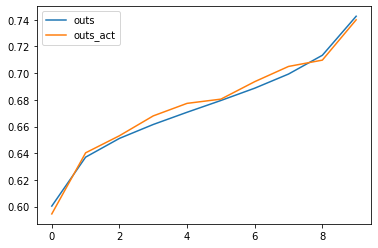

In [230]:
X_merge['outs'] = X_merge[['so', 'fo', 'go', 'lo', 'po']].sum(axis=1)
X_merge.loc[X_merge['eventsModel'].isin(['so', 'fo', 'go', 'lo', 'po']), 'outs_act'] = 1
X_merge['outs_act'].fillna(0, inplace=True)

X_merge[['outs', 'outs_act']]

X_merge['decile'] = pd.qcut(X_merge['outs'], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[['outs', 'outs_act']].plot.line())
test['outs_mse'] = (test['outs'] - test['outs_act']) ** 2
print(test['outs_mse'].mean())

2020l 1.5441999816867803e-05 perfect <br>
2222l 2.1262490527763598e-05 very good <br>

AxesSubplot(0.125,0.125;0.775x0.755)
4.814078470281203e-05


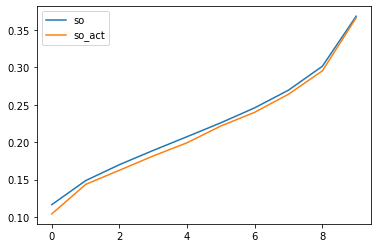

In [231]:
var = "so"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())

test['so_mse'] = (test['so'] - test['so_act']) ** 2
print(test['so_mse'].mean())

2020l 0.00023636926096063299 so_act > <br>
2222l 4.814078470281203e-05 very good <br>

AxesSubplot(0.125,0.125;0.775x0.755)
1.0804973665838658e-06


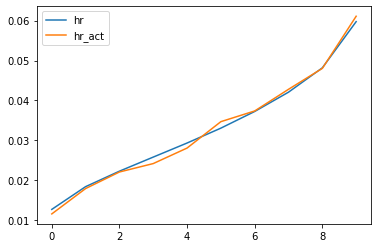

In [232]:
var = "hr"
X_merge[f'{var}_act'] = (X_merge['eventsModel'] == var).astype('int')
X_merge['decile'] = pd.qcut(X_merge[var], 10, labels=False)
test = X_merge.groupby('decile').mean().reset_index()

print(test[[var, f'{var}_act']].plot.line())
test['hr_mse'] = (test['hr'] - test['hr_act']) ** 2
print(test['hr_mse'].mean())

2020l 0.00011036702089449717 hr_act >>> <br>
2222l 1.0804973665838658e-06 perfect <br>

In [ ]:
# # Compute feature importances using permutation importance
# result = permutation_importance(model1b, X_test, y_test, n_repeats=10, random_state=42)
# # Print the feature importances
# listt = []
# for i, feature in enumerate(x_list1):
#     importance = result.importances_mean[i]
#     std = result.importances_std[i]
#     print(f"{feature}: {importance:.5f} +/- {std:.5f}")
#     listt.append([feature, importance, std])

# sorted_list = sorted(listt, key=lambda x: x[1])
# sorted_list

In [ ]:
# # Create a GridSearchCV object
# grid_search = GridSearchCV(cv=5,
#                            estimator=MLPClassifier(max_iter=100),
#                            param_grid={'hidden_layer_sizes': [(50)],
#                            'activation': ['relu'],
#                            'alpha': [0.001]},
#                            scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1, verbose=5)    

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train_scaled, y_train)

# # Print the best parameter setting
# print(grid_search.best_params_)
# print(grid_search.best_score_)

# # model = MLPClassifier(hidden_layer_sizes=(200,200,200), activation='relu', random_state=1,max_iter=500).fit(X_train_scaled, y_train)
# # preds = model.predict_proba(X_test)

# # print("Train score:", model.score(X_train_scaled, y_train))
# # print("Test score:", model.score(X_test_scaled, y_test))


In [ ]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# # Assume X is your time series data and y is your target variable
# tscv = TimeSeriesSplit(n_splits=5)

# # Loop over each fold
# for train_index, test_index in tscv.split(X):
#     # get the training and test data for this fold
#     X_train, X_test = X.loc[train_index], X.loc[test_index]
#     y_train, y_test = y.loc[train_index], y.loc[test_index]
    
#     # train and evaluate your model on this fold
#     model = MLPClassifier(hidden_layer_sizes=(200,200,200), activation='relu', verbose=True, random_state=1, max_iter=10).fit(X_train, y_train)

#     # model.fit(X_train, y_train)
#     score = model.score(X_test, y_test)
    
#     # do whatever you need to with the score for this fold
#     print("Fold score:", score)